In [1]:
#basic imports
import pandas as pd
import numpy as np
import math
#ml stuff
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
#metrics + sklearn
from scipy import spatial
from hdbscan import HDBSCAN
from sklearn import metrics
from sklearn import decomposition
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np 
#data visualization
import plotly.graph_objs as go
import plotly
import hiplot as hip

C:\Users\madke\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [219]:


def filter_perc(df, perc = 0.25):
    aware = df.copy()
    aware = aware.loc[:, aware.isna().mean() < perc]
    aware = aware.loc[:, (aware==0).mean() < perc]
    aware = aware.loc[aware.isna().mean(axis = 1) < perc, :]
    aware = aware.loc[(aware==0).mean(axis = 1) < perc, :]
    return(aware)

def pad_rows(sequence, n_keep = 10):
    pad_imp = []
    for i in sequence:
        if len(i['index']) >= n_keep:
            pad_imp.append(np.array(i.iloc[0:n_keep,:]))
        else:
            count = n_keep - len(i['index'])
            for z in range(0,count):
                i.loc[len(i)] = 0
            pad_imp.append(np.array(i))
    return(pad_imp)


# split a  sequence into samples
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequence(sequence, n_steps = 3):
    X, y = list(), list()
    for i in range(sequence.shape[0]):
# find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > sequence.shape[0] -1:
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# this function does not actually create a hiplot object, but converts keras history into a list of dictionaries interperable
#by hiplot.  takes the history object and a series of relevant labels
def create_hiplot(hist_ob, activ, lr, KI, lf, random_state):
    hist_df = pd.DataFrame(hist_ob.history)
    hist = hist_df.to_dict('records')
    trial_num = 0
    for i in hist:
        dict1 = {'activation': activ, 'lr': lr, 'KI': KI, 'lossfxn': lf, 'random_state': random_state, 'epoch': trial_num}
        trial_num +=1
        i = i.update(dict1)
    return(hist)

#this allows you to add multiple history objects to the input for hiplot (desirable for comparing models)       
def update_hiplot(hipl, hist_ob, activ, lr, KI, lf, random_state):
    hist_df = pd.DataFrame(hist_ob.history)
    hist = hist_df.to_dict('records')
    trial_num = 0
    for i in hist:
        dict1 = {'activation': activ, 'lr': lr, 'KI': KI, 'lossfxn': lf,'random_state': random_state, 'epoch': trial_num}
        trial_num +=1
        i = i.update(dict1)
    return(hipl + hist)

#this allows you to remove content from specific iterations 
def delete_from_hiplot(hip1, activ, encoder):
    hi2 = []
    for i in hip1:
        if i['activation'] != activ or i['encoder'] != encoder:
            hi2.append(i)
    return(hi2)

In [ ]:
#aware merge will strip down to 120
aware = pd.read_csv('/users/madke/downloads/aware_personality_8-4.csv', index_col = 0)
awaregb = aware.groupby('participantID')

aware['localDate'] =pd.to_datetime(aware.localDate)

aware = filter_perc(aware)

In [176]:
aware.head().style

,localDate,participantID,batteryDischargeCount.daily,batteryDischargeDuration.sum.daily,batteryConsumptionRate.mean.daily,batteryConsumptionRate.max.daily,batteryChargeCount.daily,batteryChargeDuration.sum.daily,batteryDischargeCount.morning,batteryDischargeDuration.sum.morning,batteryConsumptionRate.mean.morning,batteryConsumptionRate.max.morning,batteryDischargeCount.afternoon,batteryDischargeDuration.sum.afternoon,batteryConsumptionRate.mean.afternoon,batteryConsumptionRate.max.afternoon,batteryDischargeCount.evening,batteryDischargeDuration.sum.evening,batteryConsumptionRate.mean.evening,batteryConsumptionRate.max.evening,batteryChargeCount.evening,batteryChargeDuration.sum.evening,screenUnlockCount.daily,screenUnlockRatio.daily,screenUnlockDuration.sum.daily,screenUnlockDuration.max.daily,screenUnlockDuration.min.daily,screenUnlockDuration.mean.daily,screenUnlockDuration.std.daily,screenUnlockCount.morning,screenUnlockRatio.morning,screenUnlockDuration.sum.morning,screenUnlockDuration.max.morning,screenUnlockDuration.min.morning,screenUnlockDuration.mean.morning,screenUnlockCount.afternoon,screenUnlockRatio.afternoon,screenUnlockDuration.sum.afternoon,screenUnlockDuration.max.afternoon,screenUnlockDuration.min.afternoon,screenUnlockDuration.mean.afternoon,screenUnlockDuration.std.afternoon,screenUnlockCount.evening,screenUnlockRatio.evening,screenUnlockDuration.sum.evening,screenUnlockDuration.max.evening,screenUnlockDuration.min.evening,screenUnlockDuration.mean.evening,screenUnlockDuration.std.evening,wifiCount.daily,wifiUniqueDevice.daily,wifiMostUniqueScan.daily,wifiCount.morning,wifiUniqueDevice.morning,wifiCount.afternoon,wifiUniqueDevice.afternoon,wifiCount.evening,wifiUniqueDevice.evening,neoConscientiousness,neoNeuroticism,neoExtraversion,neoAgreeableness,neoOpenness,NegativeAffectivity,Detachment,Antagonism,Disinhibition,Psychoticism
1,2017-10-24 00:00:00,221,3.000000,713.351183,0.238534,0.346076,6.000000,159.962383,2.000000,226.228383,0.262690,0.346076,2.000000,295.800000,0.184763,0.190223,1.000000,191.266667,0.190223,0.190223,2.000000,48.967067,85.000000,0.059028,131.950717,26.905433,0.053617,1.552361,3.705076,24.000000,0.066667,70.927100,26.905433,0.065033,2.955296,50.000000,0.138889,37.927150,3.530550,0.053617,0.758543,0.748027,11.000000,0.030556,23.096467,6.228350,0.505200,2.099679,2.052827,29405.000000,2395.000000,592.000000,9932.000000,1394.000000,13252.000000,1300.000000,2528.000000,134.000000,3.916667,1.291667,2.625000,3.708333,3.291667,0.268254,0.507937,0.242857,1.121599,0.222222
2,2017-10-25 00:00:00,221,2.000000,867.942700,0.175945,0.195971,3.000000,119.074550,1.000000,279.566667,0.155919,0.155919,1.000000,271.983333,0.155919,0.155919,1.000000,316.372817,0.195971,0.195971,2.000000,38.116667,67.000000,0.046528,56.250117,9.996817,0.057333,0.839554,1.513764,33.000000,0.091667,23.704317,3.603600,0.061333,0.718313,28.000000,0.077778,18.345633,4.200000,0.057333,0.655201,0.827880,7.000000,0.019444,14.185450,9.996817,0.117433,2.026493,3.557599,19315.000000,1186.000000,334.000000,2784.000000,58.000000,11428.000000,916.000000,5103.000000,330.000000,3.916667,1.291667,2.625000,3.708333,3.291667,0.268254,0.507937,0.242857,1.121599,0.222222
3,2017-10-26 00:00:00,221,3.000000,805.688250,0.248630,0.276394,5.000000,207.904050,1.000000,287.500000,0.263665,0.263665,2.000000,271.500000,0.270030,0.276394,2.000000,246.650383,0.241113,0.276394,2.000000,90.241217,117.000000,0.081250,154.544267,11.144467,0.033333,1.320891,1.737216,46.000000,0.127778,64.490217,7.505800,0.050200,1.401961,61.000000,0.169444,78.088750,11.144467,0.033333,1.280143,1.906930,10.000000,0.027778,11.965300,5.577233,0.099267,1.196530,1.648871,32916.000000,2812.000000,585.000000,10339.000000,1163.000000,14039.000000,1224.000000,5003.000000,847.000000,3.916667,1.291667,2.625000,3.708333,3.291667,0.268254,0.507937,0.242857,1.121599,0.222222
4,2017-10-27 00:00:00,221,6.000000,630.007767,0.344401,0.560385,6.000000,185.855017,2.000000,258.889600,0.312307,0.34

In [177]:
sequences = []
for i in list(set(aware['participantID'])):
    unit = awaregb.get_group(i)
    unit = unit.sort_values(by='localDate')
    unit = unit.reset_index(drop = True)
    sequences.append(unit.reset_index(drop = False))


imp_seq = []
for i in sequences:
    needs_fixed = i.iloc[:,2:(len(i.columns)-10)]
    fixed = needs_fixed.fillna(needs_fixed.mean())
    fixed = fixed.fillna(0)
    new = pd.concat([i.iloc[:,0:2], fixed, i.iloc[:, (len(i.columns)-10):(len(i.columns))]], axis = 1)
    imp_seq.append(new)
  

In [213]:
indep_vars = [i.drop(['participantID', 'localDate'], axis = 1) for i in imp_seq]
pad_imp = pad_rows(indep_vars)  

In [179]:
X_ls = []
y_ls = []
for i in pad_imp:
    X, y = split_sequence(i)
    X_ls.append(X)
    y_ls.append(y)

In [171]:
X.shape

(17, 3, 395)

In [180]:
dep_vars_ls = y_ls
indep_vars_ls =X_ls


# normalize the dataset
y = np.vstack(dep_vars_ls)
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)
y = np.where(np.isnan(y),0,y)

# normalize the dataset
X1 = np.vstack(indep_vars_ls)

X = X1.reshape(X1.shape[0]*X1.shape[1],X1.shape[2])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X = X.reshape(X1.shape[0], X1.shape[1],X1.shape[2])
X = np.where(np.isnan(X),0,X)
#[samples, timesteps, features]

In [163]:
X.shape

(1955, 3, 395)

In [216]:
random = 1

np.random.seed(random)
tf.compat.v1.random.set_random_seed(random)

learn = 0.0001
opt = tf.optimizers.Adam(lr= learn, amsgrad = True)

loss_fctn = 'mean_squared_error'
activ_h = 'tanh'  #selu, tanh
KI_h = 'glorot_uniform'
activ_d = 'sigmoid'
n_steps, n_features = X.shape[1], X.shape[2]


model = Sequential()
model.add(LSTM(200, activation=activ_h, kernel_initializer = KI_h, return_sequences = True, recurrent_dropout = 0.3, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation=activ_h, kernel_initializer = KI_h,  return_sequences = True, recurrent_dropout = 0.3,  input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation=activ_h, kernel_initializer = KI_h, recurrent_dropout = 0.3,  input_shape=(n_steps, n_features)))
model.add(Dense(395, input_shape=(n_steps, n_features), activation=activ_d))
model.compile(loss=loss_fctn, optimizer=opt,  metrics=['acc', 'mae', 'msle', 'mse'])

In [217]:
history = model.fit(X, y,  batch_size=10, epochs=200, verbose=1, validation_split = 0.2)

Train on 1523 samples, validate on 381 samples
Epoch 1/200
1523/1523 [==============================] - 6s 4ms/step - loss: 0.1208 - acc: 0.2403 - mae: 0.2936 - msle: 0.0784 - mse: 0.1208 - val_loss: 0.0544 - val_acc: 0.5774 - val_mae: 0.1569 - val_msle: 0.0341 - val_mse: 0.0544
Epoch 2/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0346 - acc: 0.3913 - mae: 0.1138 - msle: 0.0209 - mse: 0.0346 - val_loss: 0.0389 - val_acc: 0.0000e+00 - val_mae: 0.1240 - val_msle: 0.0239 - val_mse: 0.0389
Epoch 3/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0291 - acc: 0.1523 - mae: 0.0964 - msle: 0.0170 - mse: 0.0291 - val_loss: 0.0319 - val_acc: 0.0000e+00 - val_mae: 0.1036 - val_msle: 0.0187 - val_mse: 0.0319
Epoch 4/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0277 - acc: 0.2167 - mae: 0.0905 - msle: 0.0159 - mse: 0.0277 - val_loss: 0.0307 - val_acc: 0.0000e+00 - val_mae: 0.0982 - val_msle: 0.0177 - val_mse: 0.0307
Epoch 5/2

Epoch 36/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0189 - acc: 0.5292 - mae: 0.0692 - msle: 0.0107 - mse: 0.0189 - val_loss: 0.0210 - val_acc: 0.5433 - val_mae: 0.0739 - val_msle: 0.0121 - val_mse: 0.0210
Epoch 37/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0186 - acc: 0.5266 - mae: 0.0689 - msle: 0.0106 - mse: 0.0186 - val_loss: 0.0206 - val_acc: 0.5354 - val_mae: 0.0729 - val_msle: 0.0117 - val_mse: 0.0206
Epoch 38/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0185 - acc: 0.5299 - mae: 0.0682 - msle: 0.0104 - mse: 0.0185 - val_loss: 0.0203 - val_acc: 0.5381 - val_mae: 0.0726 - val_msle: 0.0115 - val_mse: 0.0203
Epoch 39/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0182 - acc: 0.5259 - mae: 0.0679 - msle: 0.0103 - mse: 0.0182 - val_loss: 0.0202 - val_acc: 0.5486 - val_mae: 0.0721 - val_msle: 0.0115 - val_mse: 0.0202
Epoch 40/200
1523/1523 [==============================] - 6s 4ms

1523/1523 [==============================] - 4s 3ms/step - loss: 0.0154 - acc: 0.4603 - mae: 0.0592 - msle: 0.0086 - mse: 0.0154 - val_loss: 0.0178 - val_acc: 0.4908 - val_mae: 0.0635 - val_msle: 0.0099 - val_mse: 0.0178
Epoch 72/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0154 - acc: 0.4760 - mae: 0.0590 - msle: 0.0085 - mse: 0.0154 - val_loss: 0.0176 - val_acc: 0.5722 - val_mae: 0.0633 - val_msle: 0.0098 - val_mse: 0.0176
Epoch 73/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0153 - acc: 0.5213 - mae: 0.0589 - msle: 0.0085 - mse: 0.0153 - val_loss: 0.0178 - val_acc: 0.5433 - val_mae: 0.0635 - val_msle: 0.0100 - val_mse: 0.0178
Epoch 74/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0153 - acc: 0.4793 - mae: 0.0588 - msle: 0.0085 - mse: 0.0153 - val_loss: 0.0177 - val_acc: 0.5774 - val_mae: 0.0627 - val_msle: 0.0098 - val_mse: 0.0177
Epoch 75/200
1523/1523 [==============================] - 4s 3ms/step - loss:

1523/1523 [==============================] - 4s 3ms/step - loss: 0.0143 - acc: 0.4544 - mae: 0.0557 - msle: 0.0079 - mse: 0.0143 - val_loss: 0.0175 - val_acc: 0.5433 - val_mae: 0.0612 - val_msle: 0.0097 - val_mse: 0.0175
Epoch 107/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0143 - acc: 0.4747 - mae: 0.0557 - msle: 0.0079 - mse: 0.0143 - val_loss: 0.0174 - val_acc: 0.5276 - val_mae: 0.0609 - val_msle: 0.0097 - val_mse: 0.0174
Epoch 108/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0143 - acc: 0.4406 - mae: 0.0556 - msle: 0.0079 - mse: 0.0143 - val_loss: 0.0175 - val_acc: 0.5223 - val_mae: 0.0609 - val_msle: 0.0097 - val_mse: 0.0175
Epoch 109/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0143 - acc: 0.4419 - mae: 0.0556 - msle: 0.0080 - mse: 0.0143 - val_loss: 0.0176 - val_acc: 0.5459 - val_mae: 0.0618 - val_msle: 0.0099 - val_mse: 0.0176
Epoch 110/200
1523/1523 [==============================] - 4s 3ms/step - l

Epoch 141/200
1523/1523 [==============================] - 6s 4ms/step - loss: 0.0133 - acc: 0.3959 - mae: 0.0533 - msle: 0.0074 - mse: 0.0133 - val_loss: 0.0169 - val_acc: 0.4646 - val_mae: 0.0592 - val_msle: 0.0093 - val_mse: 0.0169
Epoch 142/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0132 - acc: 0.4307 - mae: 0.0532 - msle: 0.0073 - mse: 0.0132 - val_loss: 0.0169 - val_acc: 0.4882 - val_mae: 0.0592 - val_msle: 0.0093 - val_mse: 0.0169
Epoch 143/200
1523/1523 [==============================] - 5s 3ms/step - loss: 0.0132 - acc: 0.4209 - mae: 0.0530 - msle: 0.0073 - mse: 0.0132 - val_loss: 0.0169 - val_acc: 0.4803 - val_mae: 0.0594 - val_msle: 0.0094 - val_mse: 0.0169
Epoch 144/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0132 - acc: 0.4353 - mae: 0.0531 - msle: 0.0073 - mse: 0.0132 - val_loss: 0.0169 - val_acc: 0.5066 - val_mae: 0.0589 - val_msle: 0.0093 - val_mse: 0.0169
Epoch 145/200
1523/1523 [==============================] - 4

Epoch 176/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0122 - acc: 0.2823 - mae: 0.0506 - msle: 0.0067 - mse: 0.0122 - val_loss: 0.0166 - val_acc: 0.3648 - val_mae: 0.0583 - val_msle: 0.0092 - val_mse: 0.0166
Epoch 177/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0121 - acc: 0.3033 - mae: 0.0506 - msle: 0.0067 - mse: 0.0121 - val_loss: 0.0167 - val_acc: 0.3386 - val_mae: 0.0578 - val_msle: 0.0092 - val_mse: 0.0167
Epoch 178/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0121 - acc: 0.3093 - mae: 0.0505 - msle: 0.0067 - mse: 0.0121 - val_loss: 0.0165 - val_acc: 0.3596 - val_mae: 0.0581 - val_msle: 0.0091 - val_mse: 0.0165
Epoch 179/200
1523/1523 [==============================] - 4s 3ms/step - loss: 0.0121 - acc: 0.2902 - mae: 0.0503 - msle: 0.0067 - mse: 0.0121 - val_loss: 0.0166 - val_acc: 0.3622 - val_mae: 0.0578 - val_msle: 0.0091 - val_mse: 0.0166
Epoch 180/200
1523/1523 [==============================] - 4

In [138]:
#hip1 = create_hiplot(history,  activ = activ_h, lr = learn, KI = KI_h, lf = loss_fctn, random_state = random)
hip1 = update_hiplot(hip1, history, activ = activ_h, lr = learn, KI = KI_h, lf = loss_fctn, random_state = random)


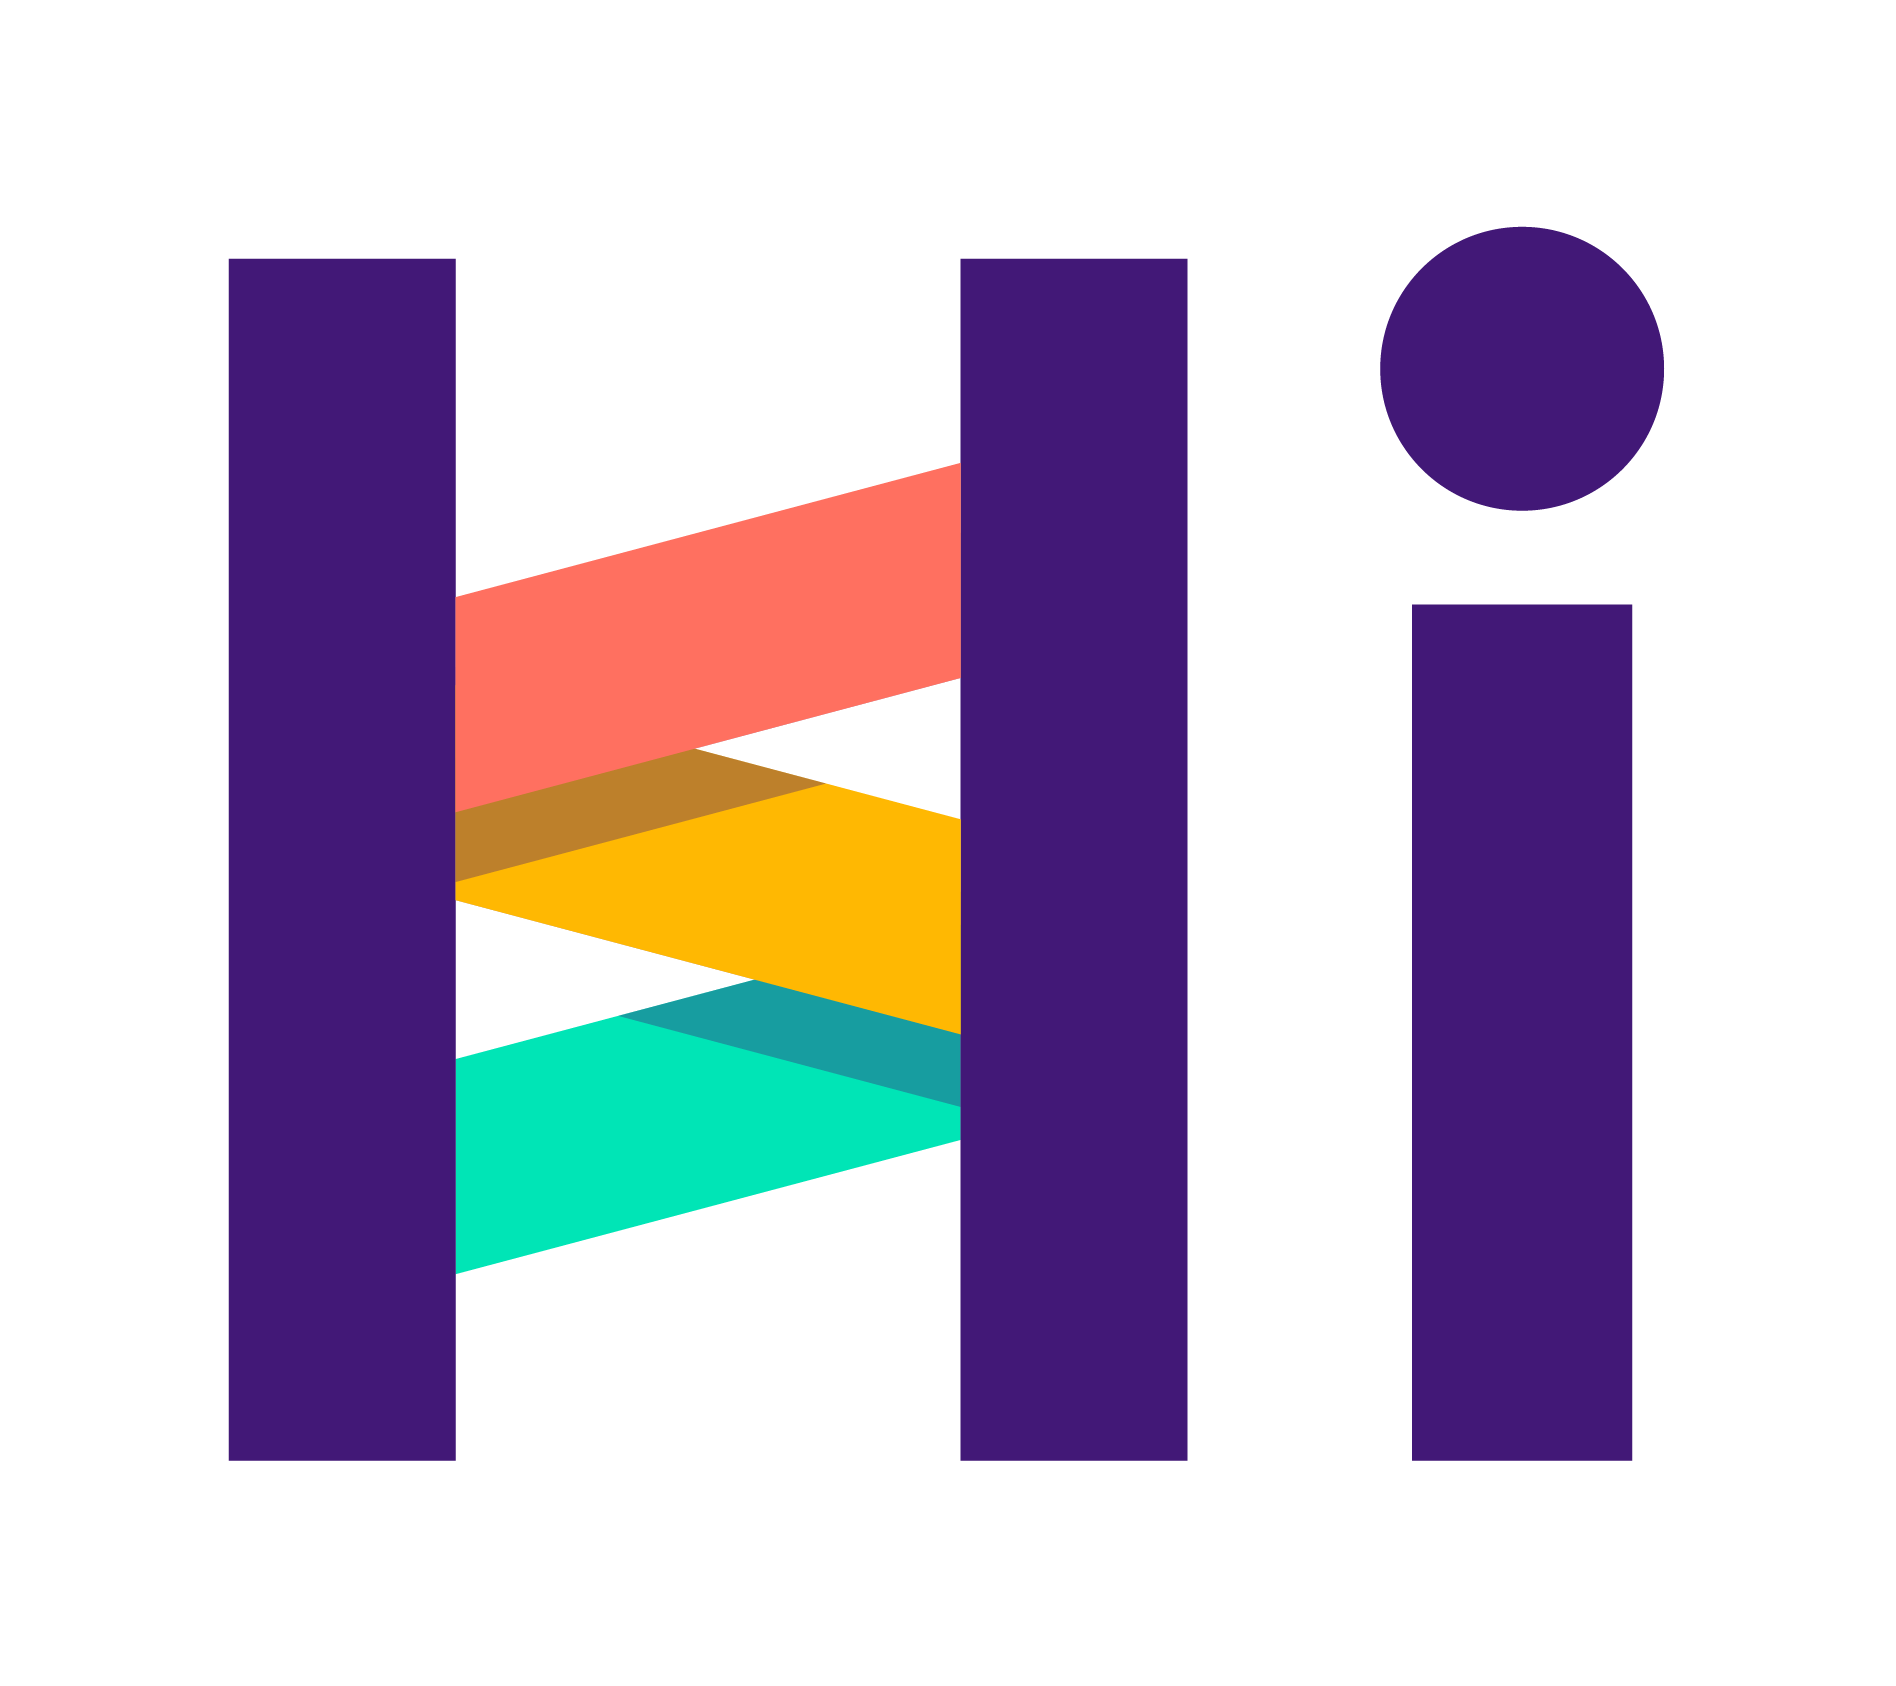

<IPython.core.display.Javascript object>

In [139]:
hip.Experiment.from_iterable(hip1).display(force_full_width=False)

In [77]:
np.random.seed(300)
tf.compat.v1.random.set_random_seed(2005)

learn = 0.01
opt = tf.optimizers.Adam(lr= learn, amsgrad = True)
#opt = tf.optimizers.Adadelta(lr= learn)

loss_fctn = 'mean_squared_error'
activ_h = 'tanh'  #selu, tanh
KI_h = 'glorot_uniform'

model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
#model.add(Dense(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
#model.add(Dense(25, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activ_h, kernel_initializer=KI_h))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.4,dropout=0.4))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, recurrent_dropout = 0.2,   dropout=0.2))
model.add(LSTM(32, activation=activ_h, kernel_initializer=KI_h, return_sequences=True, recurrent_dropout = 0.2,   dropout=0.2))
model.add(LSTM(32))
model.add(Dense(16, input_dim=32, activation=activ_h, kernel_initializer=KI_h))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss=loss_fctn, optimizer=opt,  metrics=['acc', 'mae', 'msle', 'mse'])
 


NameError: name 'X_train' is not defined